# simple RNN
### バイナリ加算

iters:0
Loss:0.908519068881
Pred:[1 1 1 1 1 1 1 0]
True:[1 1 0 1 0 0 1 0]
84 + 126 = 254
------------
iters:100
Loss:1.01895019485
Pred:[1 1 1 1 1 1 1 0]
True:[1 0 1 0 1 0 1 0]
60 + 110 = 254
------------
iters:200
Loss:1.11231624057
Pred:[0 0 0 0 0 0 1 0]
True:[0 1 1 1 0 0 0 0]
22 + 90 = 2
------------
iters:300
Loss:1.10129830444
Pred:[1 1 1 1 1 1 1 0]
True:[0 1 1 1 0 0 1 1]
4 + 111 = 254
------------
iters:400
Loss:1.03507661935
Pred:[0 0 0 0 0 0 1 1]
True:[0 0 1 0 1 1 0 1]
19 + 26 = 3
------------
iters:500
Loss:0.964689179931
Pred:[0 1 1 1 0 1 1 0]
True:[1 1 0 1 1 1 0 0]
110 + 110 = 118
------------
iters:600
Loss:0.942750585705
Pred:[1 1 1 1 1 1 1 0]
True:[1 0 0 1 1 1 1 1]
102 + 57 = 254
------------
iters:700
Loss:1.13250320455
Pred:[1 1 1 1 1 1 1 0]
True:[1 0 0 0 0 1 0 0]
84 + 48 = 254
------------
iters:800
Loss:0.962064874291
Pred:[0 0 0 0 0 0 1 0]
True:[0 1 1 0 0 0 1 1]
64 + 35 = 2
------------
iters:900
Loss:0.92092522084
Pred:[0 0 0 0 0 0 0 1]
True:[1 0 0 0 0 0 0 0]
59 + 6

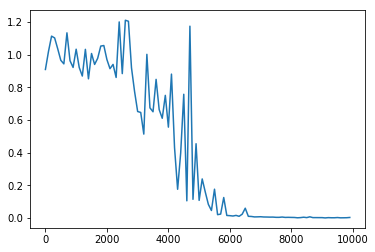

In [34]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common import functions
import matplotlib.pyplot as plt

# def d_tanh(x):



# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16  # original 16
output_layer_size = 1

weight_init_std = 1     # original 1
learning_rate = 0.1     # original 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# Xavier


# He



# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])

        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## [try] weight_init_stdやlearning_rate, hidden_layer_sizeを変更してみよう

`考察`

- 各ソースに直接修正して確認した

## [try] 重みの初期化方法を変更してみよう - Xavier


iters:0
Loss:1.13411695405
Pred:[0 0 0 0 0 0 0 0]
True:[1 1 1 0 0 0 1 1]
126 + 101 = 0
------------
iters:100
Loss:0.95680110506
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 1 1 0 0 0 0]
26 + 86 = 0
------------
iters:200
Loss:1.04870273705
Pred:[1 1 1 1 1 1 1 1]
True:[1 0 0 1 0 0 0 0]
32 + 112 = 255
------------
iters:300
Loss:1.14470905549
Pred:[1 1 1 1 1 1 1 1]
True:[0 1 0 0 0 0 0 1]
51 + 14 = 255
------------
iters:400
Loss:0.964641315489
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 1 0 0 0 0]
123 + 53 = 0
------------
iters:500
Loss:0.988820067332
Pred:[1 1 1 1 1 1 1 1]
True:[0 0 1 1 1 0 1 0]
14 + 44 = 255
------------
iters:600
Loss:1.01554583509
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 0 0 1 1 1 0]
114 + 28 = 0
------------
iters:700
Loss:1.10812906608
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 1 1 1 1 1 0]
46 + 80 = 0
------------
iters:800
Loss:1.03399338411
Pred:[0 1 1 1 1 0 0 0]
True:[0 1 0 0 0 0 1 0]
56 + 10 = 120
------------
iters:900
Loss:0.946479931788
Pred:[1 1 1 1 1 1 1 1]
True:[0 1 1 1 1 0 0 1]
13 + 108 = 

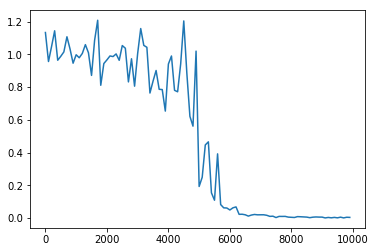

In [33]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common import functions
import matplotlib.pyplot as plt

# def d_tanh(x):



# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16  # original 16
output_layer_size = 1

weight_init_std = 1     # original 1
learning_rate = 0.1     # original 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
# W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
# W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
# W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# Xavier　【レポート提出者変更】
W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))

# He



# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])

        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

## [try] 重みの初期化方法を変更してみよう - He


iters:0
Loss:1.82756273781
Pred:[1 1 1 1 1 1 1 1]
True:[1 0 0 0 1 0 0 1]
28 + 109 = 255
------------
iters:100
Loss:1.02109291147
Pred:[1 1 1 1 1 0 0 1]
True:[1 0 0 0 0 0 0 1]
123 + 6 = 249
------------
iters:200
Loss:0.916334831281
Pred:[1 1 1 1 1 1 1 1]
True:[0 1 1 1 1 0 1 1]
50 + 73 = 255
------------
iters:300
Loss:1.02219929786
Pred:[1 1 1 1 1 1 1 1]
True:[1 0 1 0 1 0 1 0]
58 + 112 = 255
------------
iters:400
Loss:1.20871130942
Pred:[1 1 1 1 1 1 1 1]
True:[1 0 0 0 1 0 0 0]
90 + 46 = 255
------------
iters:500
Loss:1.0461303671
Pred:[0 0 0 0 1 1 1 0]
True:[0 0 1 1 0 0 1 0]
35 + 15 = 14
------------
iters:600
Loss:0.907327468362
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 1 0 0 0 0 1]
40 + 57 = 0
------------
iters:700
Loss:0.992003935073
Pred:[0 0 0 0 0 1 0 1]
True:[1 1 0 1 0 0 1 0]
107 + 103 = 5
------------
iters:800
Loss:0.870132600545
Pred:[1 1 0 0 0 1 0 1]
True:[1 1 0 0 0 1 0 1]
96 + 101 = 197
------------
iters:900
Loss:1.07028829207
Pred:[1 1 1 1 1 1 1 1]
True:[1 0 0 1 0 1 0 1]
49 + 1

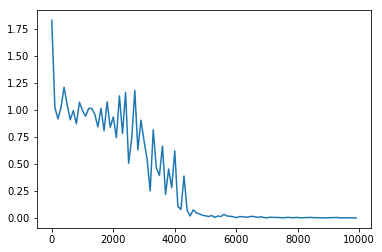

In [35]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common import functions
import matplotlib.pyplot as plt

# def d_tanh(x):



# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16  # original 16
output_layer_size = 1

weight_init_std = 1     # original 1
learning_rate = 0.1     # original 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
# W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
# W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
# W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# Xavier
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))

# He　【レポート提出者変更】
W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)


# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])

        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

## [try] 中間層の活性化関数を変更してみよう - ReLU(勾配爆発を確認しよう)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

iters:0
Loss:2.0
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 0 0 0 1 1 1]
65 + 70 = 0
------------
iters:100
Loss:2.0
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 1 0 0 1 0 1]
11 + 90 = 0
------------
iters:200
Loss:2.0
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 0 0 1 1 0 1]
35 + 106 = 0
------------
iters:300
Loss:2.0
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 0 0 0 1 1 1]
100 + 35 = 0
------------
iters:400
Loss:1.5
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 1 1 1 0 0 0]
1 + 55 = 0
------------
iters:500
Loss:2.5
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 0 1 1 1 0 1]
60 + 33 = 0
------------
iters:600
Loss:2.0
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 1 0 1 1 0 1]
4 + 41 = 0
------------
iters:700
Loss:3.0
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 0 1 1 1 1 1]
116 + 43 = 0
------------
iters:800
Loss:2.0
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 0 0 1 0 1]
80 + 85 = 0
------------
iters:900
Loss:1.5
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 0 0 1 0 0 1]
41 + 32 = 0
------------
iters:1000
Loss:2.5
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 0 1 1 1 1 0]
11 + 83 = 0
------------
iters:1100

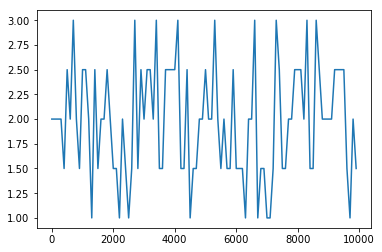

In [36]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common import functions
import matplotlib.pyplot as plt

# def d_tanh(x):



# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16  # original 16
output_layer_size = 1

weight_init_std = 1     # original 1
learning_rate = 0.1     # original 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
# W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
# W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
# W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# Xavier
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))

# He　【レポート提出者変更】
W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)


# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        
        ## 【レポート提出者変更】
        #z[:,t+1] = functions.sigmoid(u[:,t+1])
        z[:,t+1] = functions.relu(u[:,t+1])

        ## 【レポート提出者変更】
        #y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))
        y[:,t] = functions.relu(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        ## 【レポート提出者変更】
        #delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_relu(y[:,t])
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        ## 【レポート提出者変更】
        #delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

## [try] 中間層の活性化関数を変更してみよう - tanh(numpyにtanhが用意されている。導関数をd_tanhとして作成しよう)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

iters:0
Loss:1.37516526909
Pred:[0 0 0 1 1 1 1 0]
True:[0 1 0 0 1 1 1 0]
52 + 26 = 30
------------
iters:100
Loss:0.616476742876
Pred:[0 1 1 1 1 1 1 1]
True:[0 1 1 1 0 1 0 1]
87 + 30 = 127
------------
iters:200
Loss:0.722047775895
Pred:[1 0 1 1 1 1 0 0]
True:[1 0 1 1 0 0 0 0]
105 + 71 = 188
------------
iters:300
Loss:0.599751317666
Pred:[  1   0   1 255   0   1   0   1]
True:[1 0 1 0 0 0 1 1]
50 + 113 = 4245
------------
iters:400
Loss:0.869376749068
Pred:[1 1 1 0 0 1 1 0]
True:[1 1 0 0 1 0 1 0]
88 + 114 = 230
------------
iters:500
Loss:0.620249624124
Pred:[1 1 1 1 1 1 1 1]
True:[1 0 1 0 1 1 1 1]
89 + 86 = 255
------------
iters:600
Loss:0.151243759029
Pred:[0 1 0 1 0 1 1 0]
True:[0 1 0 1 0 1 1 0]
28 + 58 = 86
------------
iters:700
Loss:0.0744295439323
Pred:[1 0 1 1 1 0 0 0]
True:[1 0 1 1 1 0 0 0]
66 + 118 = 184
------------
iters:800
Loss:0.00798905197273
Pred:[1 0 0 0 1 1 1 0]
True:[1 0 0 0 1 1 1 0]
81 + 61 = 142
------------
iters:900
Loss:0.0385946784663
Pred:[1 1 0 1 0 0 1 0]


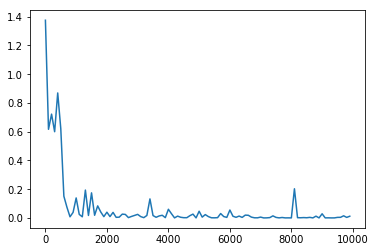

In [38]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common import functions
import matplotlib.pyplot as plt

# 【レポート提出者変更】
#
# tanh の導関数
def d_tanh(x):
    return 4 / (np.exp(x) + np.exp(-x)) ** 2




# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16  # original 16
output_layer_size = 1

weight_init_std = 1     # original 1
learning_rate = 0.1     # original 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
# W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
# W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
# W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# Xavier
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))

# He　【レポート提出者変更】
W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)


# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        
        ## 【レポート提出者変更】
        #z[:,t+1] = functions.sigmoid(u[:,t+1])
        #z[:,t+1] = functions.relu(u[:,t+1])
        z[:,t+1] = np.tanh(u[:,t+1])

        ## 【レポート提出者変更】
        #y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))
        #y[:,t] = functions.relu(np.dot(z[:,t+1].reshape(1, -1), W_out))
        y[:,t] = np.tanh(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        ## 【レポート提出者変更】
        #delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])
        #delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_relu(y[:,t])
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * d_tanh(y[:,t])
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)

        ## 【レポート提出者変更】
        #delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
        #delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])
        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

## tanhで隠れ層の数を精度向上した少し大きな数にしてみる - 32

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

iters:0
Loss:1.89570789327
Pred:[1 1 0 1 0 0 0 1]
True:[1 1 1 0 0 1 1 1]
107 + 124 = 209
------------
iters:100
Loss:1.6511793385
Pred:[255   1   0   1   1   1   1   0]
True:[1 0 0 1 1 1 0 0]
110 + 46 = 32734
------------
iters:200
Loss:1.9732788767
Pred:[1 1 1 1 1 1 1 1]
True:[0 1 1 0 0 1 0 1]
12 + 89 = 255
------------
iters:300
Loss:1.09838782754
Pred:[1 1 1 1 1 1 1 1]
True:[1 1 0 0 0 1 1 1]
88 + 111 = 255
------------
iters:400
Loss:1.79348816638
Pred:[0 1 1 1 1 1 1 1]
True:[0 1 0 0 1 0 1 0]
47 + 27 = 127
------------
iters:500
Loss:1.01983317655
Pred:[  0   1 255   0   1   1   1   1]
True:[0 1 0 1 0 1 1 1]
12 + 75 = 8239
------------
iters:600
Loss:1.84858085347
Pred:[1 1 1 1 1 1 0 1]
True:[1 0 0 1 0 0 0 1]
66 + 79 = 253
------------
iters:700
Loss:0.988973264914
Pred:[1 0 1 1 1 1 1 1]
True:[1 0 0 0 1 1 1 1]
54 + 89 = 191
------------
iters:800
Loss:2.61007417938
Pred:[1 0 0 0 0 0 1 0]
True:[0 1 1 1 0 0 1 0]
59 + 55 = 130
------------
iters:900
Loss:1.41255412048
Pred:[  1   0   1

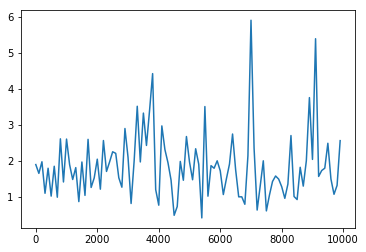

In [40]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common import functions
import matplotlib.pyplot as plt

# 【レポート提出者変更】
#
# tanh の導関数
def d_tanh(x):
    return 4 / (np.exp(x) + np.exp(-x)) ** 2




# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 32  # original 16
output_layer_size = 1

weight_init_std = 1     # original 1
learning_rate = 0.1     # original 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
# W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
# W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
# W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# Xavier
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))

# He　【レポート提出者変更】
W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)


# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        
        ## 【レポート提出者変更】
        #z[:,t+1] = functions.sigmoid(u[:,t+1])
        #z[:,t+1] = functions.relu(u[:,t+1])
        z[:,t+1] = np.tanh(u[:,t+1])

        ## 【レポート提出者変更】
        #y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))
        #y[:,t] = functions.relu(np.dot(z[:,t+1].reshape(1, -1), W_out))
        y[:,t] = np.tanh(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        ## 【レポート提出者変更】
        #delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])
        #delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_relu(y[:,t])
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * d_tanh(y[:,t])
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)

        ## 【レポート提出者変更】
        #delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
        #delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])
        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

## tanhで隠れ層の数を精度向上した少し大きな数にしてみる - 64

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

iters:0
Loss:5.43857874647
Pred:[  1 255   0   0 255 255   1   0]
True:[1 1 0 0 1 1 1 1]
89 + 118 = 19510
------------
iters:100
Loss:2.14642063431
Pred:[  0   1   1   1   1 255   0   1]
True:[1 0 0 1 0 0 1 1]
81 + 66 = 1141
------------
iters:200
Loss:1.45794305163
Pred:[0 1 1 1 0 1 0 1]
True:[0 1 1 1 0 0 1 1]
45 + 70 = 117
------------
iters:300
Loss:1.10518963684
Pred:[0 1 1 1 1 1 0 0]
True:[0 0 0 1 1 0 0 0]
12 + 12 = 124
------------
iters:400
Loss:3.74235644367
Pred:[  1   1   0   1   1   1 255   1]
True:[0 1 0 0 0 0 1 1]
25 + 42 = 731
------------
iters:500
Loss:4.06321601649
Pred:[  0   1   1 255   0   1 255   0]
True:[0 0 0 1 1 1 0 0]
26 + 2 = 4690
------------
iters:600
Loss:2.29847482469
Pred:[  1   0   1 255   1   1   0   0]
True:[0 0 1 1 1 1 0 0]
44 + 16 = 4252
------------
iters:700
Loss:1.36047840871
Pred:[255   1   1   1   1 255   1   1]
True:[0 0 1 1 0 0 1 1]
9 + 42 = 33783
------------
iters:800
Loss:1.05215646531
Pred:[  1   1   0 255   1   1   1   0]
True:[1 0 1 0 1 

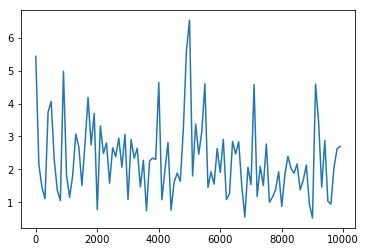

In [41]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common import functions
import matplotlib.pyplot as plt

# 【レポート提出者変更】
#
# tanh の導関数
def d_tanh(x):
    return 4 / (np.exp(x) + np.exp(-x)) ** 2




# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 64  # original 16
output_layer_size = 1

weight_init_std = 1     # original 1
learning_rate = 0.1     # original 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
# W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
# W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
# W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# Xavier
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))

# He　【レポート提出者変更】
W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)


# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        
        ## 【レポート提出者変更】
        #z[:,t+1] = functions.sigmoid(u[:,t+1])
        #z[:,t+1] = functions.relu(u[:,t+1])
        z[:,t+1] = np.tanh(u[:,t+1])

        ## 【レポート提出者変更】
        #y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))
        #y[:,t] = functions.relu(np.dot(z[:,t+1].reshape(1, -1), W_out))
        y[:,t] = np.tanh(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        ## 【レポート提出者変更】
        #delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])
        #delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_relu(y[:,t])
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * d_tanh(y[:,t])
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)

        ## 【レポート提出者変更】
        #delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
        #delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])
        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()